# Deep Learning for Diabetic Retinopathy Detection: Enhancing CNN Performance with Image Augmentation

This project involves implementing a Convolutional Neural Network (CNN) to detect diabetic retinopathy (DR) from retina images captured using fundus photography. The dataset includes images taken under various imaging conditions, challenging the model's ability to generalize across different scenarios. To improve generalization performance and mitigate the risk of overfitting, I applied advanced image transformation and data augmentation techniques. These methods enhance the training dataset by introducing variations such as rotation, scaling, and flipping, allowing the model to learn more robust features. By optimizing the CNN architecture and augmenting the dataset, the project aims to achieve high accuracy in DR detection, contributing to more effective automated diagnostic systems for diabetes-related eye diseases.

Original dataset: https://www.kaggle.com/c/aptos2019-blindness-detection/

In [ ]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

IMAGE_PATH = '/content/drive/MyDrive/CNN_images/'
LABEL_PATH = '/content/drive/MyDrive/CNN_labels/'

### About the Data

The 200 training images are fundus photography images taken by a local technicians from Aravind, a local Eye Hospital in India. The technicians visit rural areas to capture the images and the diagnosis label is provided by expert doctors. The labels correspond to the severtiy of the diabetic retinopathy (DR) on a scale of 0 to 4, where:
*  0 is No DR
*  1 is Mild
*  2 is Moderate
*  3 is Severe
*  4 is Proliferate DR

In [3]:
labels = pd.read_csv(
    LABEL_PATH + 'labels.csv'
)

print('Shape of labels:', labels.shape)
print('Unique diagnosis codes:', np.sort(labels.diagnosis.unique()))
labels.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


,id_code,diagnosis
0,000c1434d8d7,2
1,0024cdab0c1e,1
2,0083ee8054ee,4
3,00a8624548a9,2
4,00b74780d31d,2


In [4]:
images = []

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

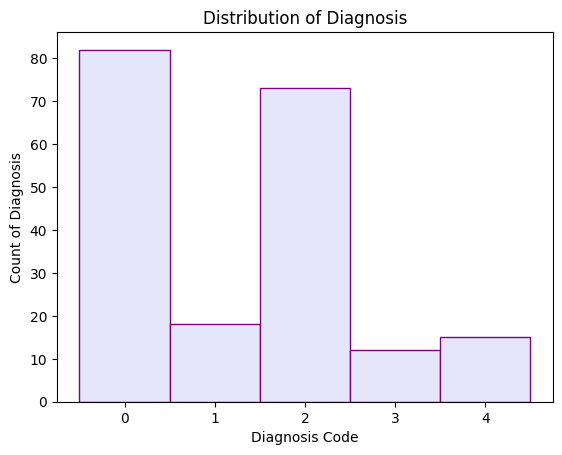

Diagnosis 0: 82 counts
Diagnosis 1: 18 counts
Diagnosis 2: 73 counts
Diagnosis 3: 12 counts
Diagnosis 4: 15 counts


In [ ]:
label_codes = [0, 1, 2, 3, 4]
counts, bins, patches = plt.hist(labels['diagnosis'], color = 'lavender', edgecolor = 'purple', bins = 5, align = 'mid')

bin_middle = (bins[:-1] + bins[1:]) / 2 # Ensure bins are in the middle of each bar
plt.xticks(bin_middle, label_codes)

# Add labels
plt.xlabel('Diagnosis Code')
plt.ylabel('Count of Diagnosis')
plt.title('Distribution of Diagnosis')
plt.show()

# Print counts
for i in range(len(counts)):
    print(f'Diagnosis {i}: {counts[i]:.0f} counts')

The distribution of diagnoses codes are imbalanced with No DR (0) and Moderate (2) having many more counts in comparison to the other codes. The counts are listed above. The size of the images varies in these 8 examples, from 600x800 pixels up to 3000x4000 pixels, with many in between. The brightness and orientation of each image also varies with some images appearing to be 'flipped' from others. Some are clearer or have more border space, while others do not.

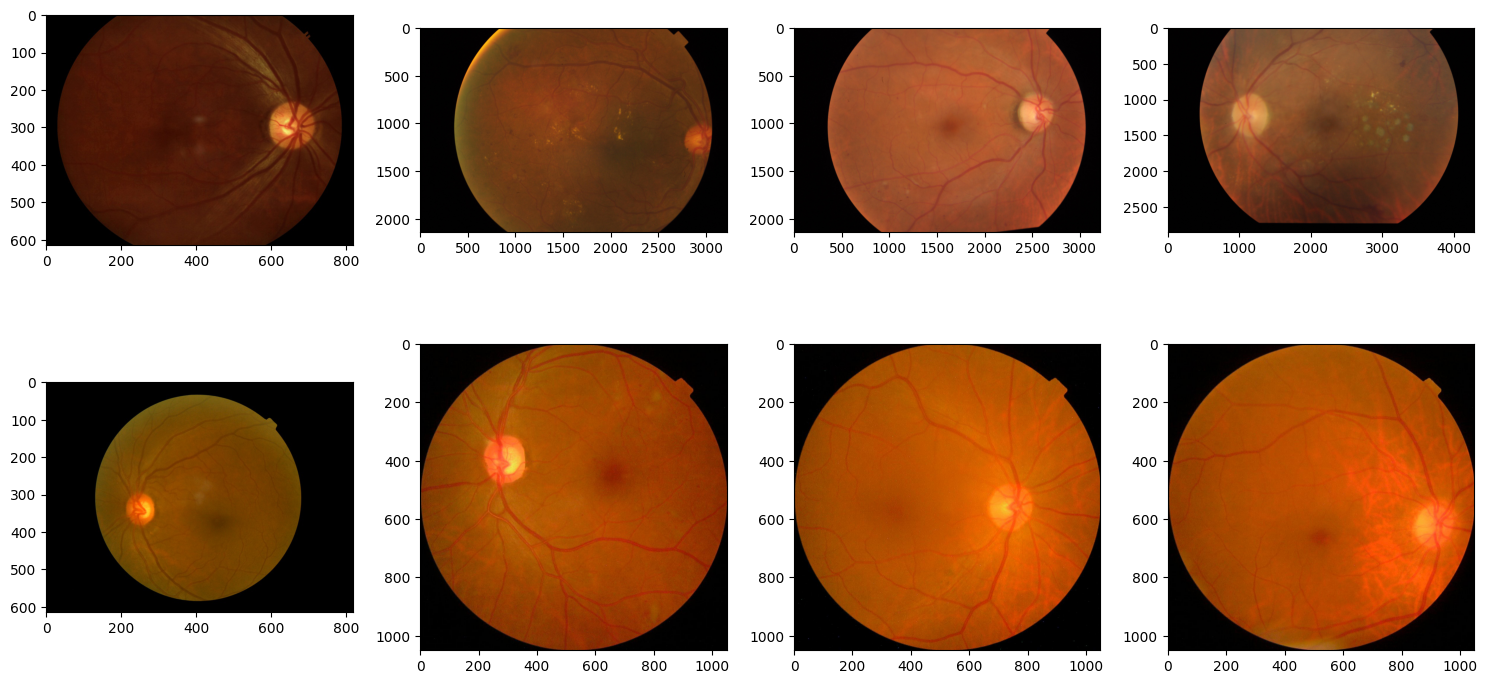

In [ ]:
fig, axes = plt.subplots(2, 4, figsize = (15,8)) # Initialize size
axes = axes.ravel()

# Print 8 images
for i in range(8):
  axes[i].imshow(images[i])

plt.tight_layout()

---
### Data preprocessing

To correct for class imbalance, we binarize the DR diagnosis and take the same number of samples from each class (80 random samples from the 'no refer' class and 80 from the 'refer')

In [7]:
np.random.seed(1234)

no_refer = labels[labels.diagnosis.isin((0,1))]
refer = labels[labels.diagnosis.isin((2,3,4))]

# randomly draw 80 images from each classes
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))

In [8]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists

    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    temp_no_refer (str): list of labels for the no refer category
    temp_refer (str): list of labels for the refer category

    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini`
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue


        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )

        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten()

    return images_mini, y_mini

In [9]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(
    IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer
)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


---
### Prepare for Modelling

This step includes shuffling data, creating the train / validation / test split and employing image transformation and augmentation

In [10]:
def preprocess_data_part2(images, labels, splits):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    labels (np.ndarray): Labels of shape (N,)
    splits (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """
    from sklearn.model_selection import train_test_split

    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # shuffle data
    # FILL IN CODE HERE #
    indices = np.arange(images.shape[0])
    shuffled_indices = np.random.permutation(indices)
    images = images[shuffled_indices]
    labels = labels[shuffled_indices]

    # create data splits (training, val, and test sets)
    # FILL IN CODE HERE #
    train_size, val_size, test_size = splits
    X_train, X_val_temp, y_train, Y_val_temp = train_test_split(images, labels, test_size = 1-train_size)
    X_val, X_test, y_val, y_test = train_test_split(X_val_temp, Y_val_temp, test_size = test_size / (val_size + test_size))

    # image augmentation (random flip) on training data
    X_train_augm = tf.image.random_flip_left_right(X_train) # FILL IN CODE HERE #

    # concatenate original X_train and augmented X_train_augm data
    X_train = tf.concat([X_train, X_train_augm], axis = 0) # FILL IN CODE HERE #

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle).numpy() # transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle).numpy() # transform y back to numpy array instead of tensor

    # rescale training, val, and test images by dividing each pixel by 255.0
    # FILL IN CODE HERE #
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0

    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 224, 224, 3)
y_train shape (192,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)
X_test shape (32, 224, 224, 3)
y_test shape (32,)


---
### Modeling

The model below uses TensorFlow to build and train a CNN model to refer patients to doctors based on the serverity of Diabetic Retinopathy in the images

In [12]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy',
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                      │ (None, 224, 224, 12)        │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         150,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,117 (590.30 KB)

 Trainable params: 151,117 (590.30 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5481 - loss: 613.9498 - val_accuracy: 0.7812 - val_loss: 1.4242
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 810ms/step - accuracy: 0.7741 - loss: 0.6948 - val_accuracy: 0.7500 - val_loss: 0.5185
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8214 - loss: 0.4687 - val_accuracy: 0.7812 - val_loss: 0.5758
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 822ms/step - accuracy: 0.8597 - loss: 0.3592 - val_accuracy: 0.7812 - val_loss: 1.3533
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8583 - loss: 0.4577 - val_accuracy: 0.7500 - val_loss: 0.6813
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 811ms/step - accuracy: 0.8429 - loss: 0.3201 - val_accuracy: 0.7812 - val_loss: 0.7032
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8932 - loss: 0.2979 - val_accuracy: 0.8438 - val_loss: 0.8666
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 810ms/step - accuracy: 0.8863 - loss: 0.2530 - val_accuracy: 0.8438 - val_loss: 0.93

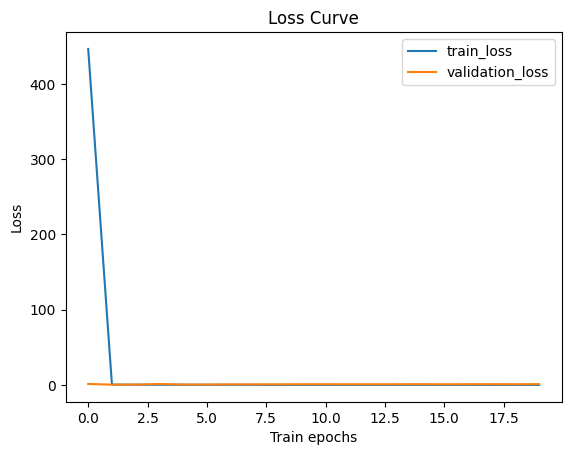

Training accuracy: 0.9271
Validation accuracy: 0.8125
Training loss: 0.1548
Validation loss: 1.2253


In [ ]:

tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model_tf = tf.keras.Sequential()

# add convolutional layer
model_tf.add(Conv2D(
    filters = 12,
    kernel_size = (4, 4),
    strides = (1, 1),
    padding = 'same',
    data_format = 'channels_last',
    name = 'conv_1',
    activation = 'relu'
))

# add max pooling layer
model_tf.add(MaxPooling2D(pool_size = (2,2)))

# add dropout layer
model_tf.add(tf.keras.layers.Dropout(
    rate = 0.3, seed = 1234
))

# add a flattening layer
model_tf.add(tf.keras.layers.Flatten())

# add the classification layer
model_tf.add(tf.keras.layers.Dense(
    units = 1,
    activation = 'sigmoid'
))

# build and compile model
model_tf.build(input_shape=(None, 224, 224, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# print model_tf summary
print(model_tf.summary())

# train model_tf on (X_train, y_train) data
history = model_tf.fit(
    x = X_train,
    y = y_train,
    epochs = 20,
    validation_data = (X_val, y_val),
    callbacks = [early_stopping]
)

# plot loss curves
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='validation_loss')
plt.xlabel('Train epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
print('Training accuracy: %1.4f' %train_accuracy[-1])
print('Validation accuracy: %1.4f' %val_accuracy[-1])
print('Training loss: %1.4f' %train_loss[-1])
print('Validation loss: %1.4f' %val_loss[-1])

My model has 151,117 trainable parameters with .9271 training accuracy and .8125 validation accuracy at the end of the 20 epochs.

#### <span style="color:blue"> Fine-Tuning the Model </span>

The model below is a result of hyperparameter tuning on the baseline. It has 151,441 trainable parameters. The fine-tuned model includes changes to the learning rate, previously 0.1 to current 0.01. The model also increases the kernel size from (4,4) to (5,5). It keeps the Adam optimizer and relu activation as this yielded the best performance upon inspection. With such improvements the training accuracy of the tuned model is 0.9479 increased .0208 from the original model. The validation accuracy is 0.9062 up .0937 from the original model. There is also a much smaller gap between the training and validaiton accuracy in the fine-tuned model, with only a .0417 difference, indicating better generalizability to unseen data.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_2 (Conv2D)                      │ (None, 224, 224, 12)        │             912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 112, 112, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 112, 112, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         150,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,441 (591.57 KB)

 Trainable params: 151,441 (591.57 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/18
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5446 - loss: 7.1362 - val_accuracy: 0.5000 - val_loss: 1.4345
Epoch 2/18
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6776 - loss: 1.0577 - val_accuracy: 0.8438 - val_loss: 0.3096
Epoch 3/18
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8360 - loss: 0.4955 - val_accuracy: 0.7812 - val_loss: 0.2988
Epoch 4/18
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8400 - loss: 0.4162 - val_accuracy: 0.8438 - val_loss: 0.2875
Epoch 5/18
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8573 - loss: 0.3779 - val_accuracy: 0.8750 - val_loss: 0.2552
Epoch 6/18
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8510 - loss: 0.3378 - val_accuracy: 0.8438 - val_loss: 0.2485
Epoch 7/18
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8560 - loss: 0.2968 - val_accuracy: 0.8125 - val_loss: 0.2455
Epoch 8/18
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8452 - loss: 0.2754 - val_accuracy: 0.8125 - val_loss: 0.2319
Epoch 

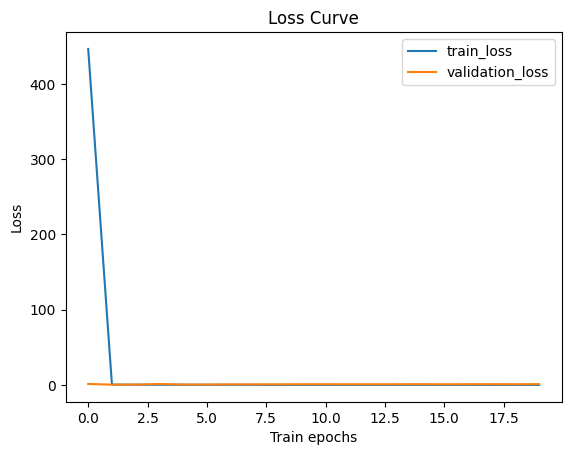

Training accuracy: 0.9479
Validation accuracy: 0.9062
Training loss: 0.1428
Validation loss: 0.3004


In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model_tf_tuned = tf.keras.Sequential()

# add convolutional layer
model_tf_tuned.add(Conv2D(
    filters = 12,
    kernel_size = (5, 5), # changed kernel size from (4,4) to (5,5) to generalize better
    strides = (1, 1),
    padding = 'same',
    data_format = 'channels_last',
    name = 'conv_2',
    activation = 'relu'
))

# add max pooling layer
model_tf_tuned.add(MaxPooling2D(pool_size = (2,2)))

# add dropout layer
model_tf_tuned.add(tf.keras.layers.Dropout(
    rate = 0.3
))

# add a flattening layer
model_tf_tuned.add(tf.keras.layers.Flatten())

# add the classification layer
model_tf_tuned.add(tf.keras.layers.Dense(
    units = 1,
    activation = 'sigmoid'
))

# build and compile model
model_tf_tuned.build(input_shape=(None, 224, 224, 3))
model_tf_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # changed learning rate from 0.1 to 0.01
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# print model_tf summary
print(model_tf_tuned.summary())

# train model_tf on (X_train, y_train) data
history2 = model_tf_tuned.fit(
    x = X_train,
    y = y_train,
    epochs = 18, # changed number of epochs to 18
    validation_data = (X_val, y_val),
    callbacks = [early_stopping]
)

# plot loss curves
train_accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']

train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='validation_loss')
plt.xlabel('Train epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
print('Training accuracy: %1.4f' %train_accuracy2[-1])
print('Validation accuracy: %1.4f' %val_accuracy2[-1])
print('Training loss: %1.4f' %train_loss2[-1])
print('Validation loss: %1.4f' %val_loss2[-1])

---
### Model Generalizability

In [ ]:
test_loss, test_accuracy = model_tf_tuned.evaluate(X_test, y_test)

print(f'The test data has a loss of: {test_loss} using the tuned model.')
print(f'The accuracy of the model using test data is: {test_accuracy}.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8438 - loss: 0.6013
The test data has a loss of: 0.6012755632400513 using the tuned model.
The accuracy of the model using test data is: 0.84375.


This model generalizes relatively well with only a .0624 difference between the validation data accuracy (90.62%) and the test data accuracy (84.38%), and a .1041 difference between the train accuracy (94.79%) and test accuracy (84.38%).